# **Import Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset**

In [3]:
column_names = ['headline', 'category']
df = pd.read_csv('/content/drive/MyDrive/datamining/labeled-dataset-2021.csv',
                 delimiter=';',
                 names=column_names)
df.head()

headline category
0         Resmi Jadi Ketua DPR Puan Semringah Banget     SDG5
1  Muzani Harap Bamsoet Mengalah Serahkan Kursi K...    SDG16
2  13 Mahasiswa UI Dapat Beasiswa Vokasi dari Pem...     SDG4
3  Kebakaran Terjadi di Permukiman Jalan S Parman...    SDG11
4  Detik-detik Penangkapan Bandar Jaringan LP Tan...    SDG16

In [4]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(4806, 2)
Unique categories: 18
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  4806 non-null   object
 1   category  4806 non-null   object
dtypes: object(2)
memory usage: 75.2+ KB


In [5]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

In [6]:
# create final dataframe of combined headline and short_description
final_df = df.copy()
final_df['length_of_news'] = final_df['headline']
final_df.drop(['headline'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

category                                     length_of_news  len_news
0     SDG5         Resmi Jadi Ketua DPR Puan Semringah Banget        42
1    SDG16  Muzani Harap Bamsoet Mengalah Serahkan Kursi K...        66
2     SDG4  13 Mahasiswa UI Dapat Beasiswa Vokasi dari Pem...        56
3    SDG11  Kebakaran Terjadi di Permukiman Jalan S Parman...        52
4    SDG16  Detik-detik Penangkapan Bandar Jaringan LP Tan...        56

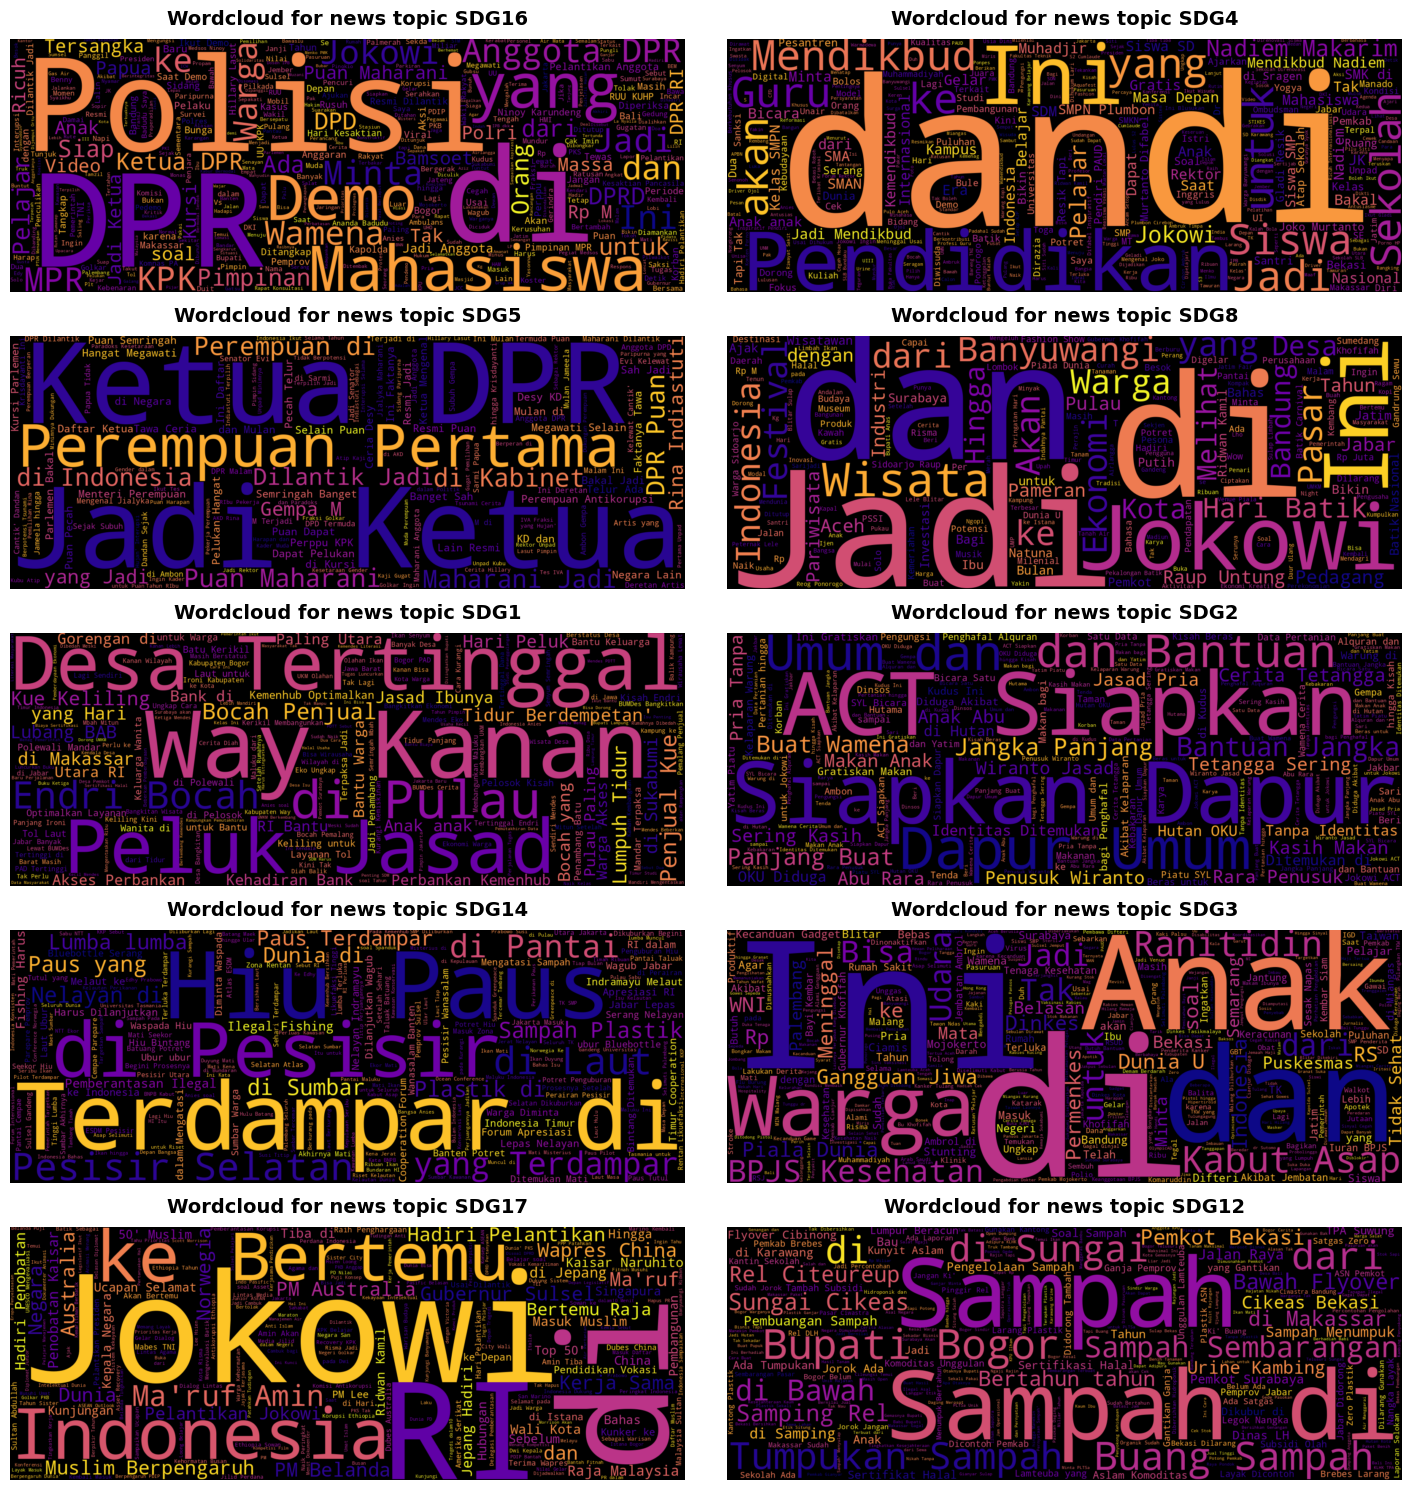

In [7]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

In [8]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

category  len_news
12     SDG4        84
16     SDG8        81
0      SDG0        80
13     SDG5        80
17     SDG9        80

In [9]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=True)
lenmin_df.head()

category  len_news
5     SDG13        11
16     SDG8        14
17     SDG9        21
11     SDG3        24
7     SDG15        24

In [10]:
ndf2 = ndf.copy()

In [11]:
# Import library
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download daftar stop words untuk bahasa Indonesia
nltk.download('stopwords')

# Mengambil daftar stop words bahasa Indonesia dari NLTK
stop_words_indonesia = set(stopwords.words('indonesian'))

# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    text = [word for word in text.split() if word not in stop_words_indonesia]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf2['length_of_news'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf2['length_of_news'][0]))

Text sentence before pre-processing:
 Resmi Jadi Ketua DPR Puan Semringah Banget
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 resmi ketua dpr puan semringah banget


In [14]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

In [15]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 292345
New chracters length of text data: 241285


In [16]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 44331
New word length of text data: 33996


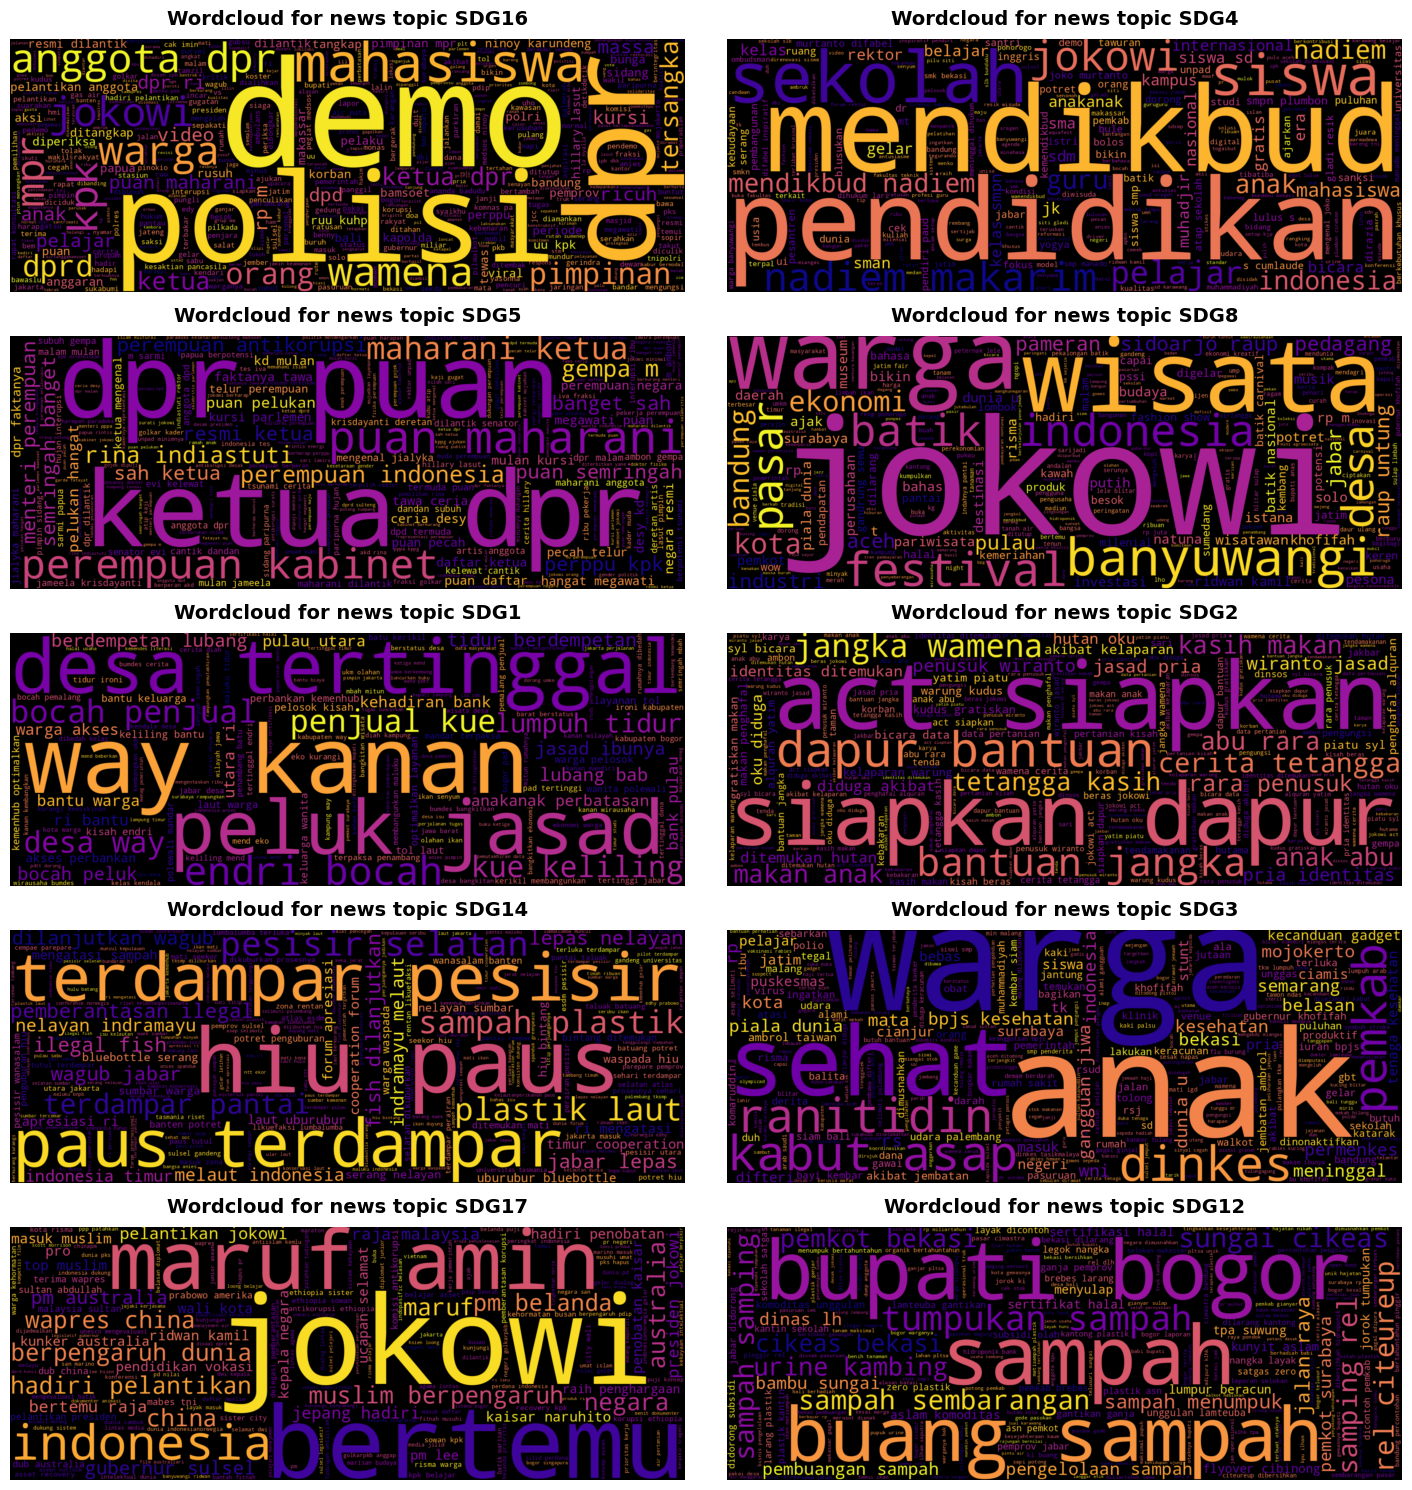

In [17]:
# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf2[ndf2['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

# **Feature Engineering**

In [18]:
# label encoding
def extract_numeric(category):
    try:
        # Extract numeric part (assuming it's at the end of the string)
        numeric_part = int(category.split('SDG')[-1])
        return numeric_part
    except ValueError:
        # Return NaN if no numeric part is found
        return None

# Apply the custom function to create a new 'label' column
ndf2['category'] = ndf2['category'].apply(extract_numeric)

In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ndf2, test_size=0.1, random_state=42, stratify=ndf2['category'])

print("Jumlah data total:", len(ndf2))
print("Jumlah data training:", len(train_df))
print("Jumlah data test:", len(test_df))

Jumlah data total: 4806
Jumlah data training: 4325
Jumlah data test: 481


# Model v0.0

In [20]:
ndf2

category                                     length_of_news
0            5              resmi ketua dpr puan semringah banget
1           16  muzani harap bamsoet mengalah serahkan kursi k...
2            4         mahasiswa ui beasiswa vokasi pemkab serang
3           11          kebakaran permukiman jalan s parman medan
4           16  detikdetik penangkapan bandar jaringan lp tanj...
...        ...                                                ...
4801        17  indonesia dukung sistem kekayaan intelektual d...
4802        17  jokowi top muslim berpengaruh pdip bantah fitn...
4803        17  jokowi masuk muslim berpengaruh dunia pks hapu...
4804        17  golkarpkb anggap jokowi layak masuk muslim ber...
4805        17  pd nilai gelar muslim berpengaruh dunia cambuk...

[4806 rows x 2 columns]

In [21]:
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
from collections import Counter
seq_len = [len(i.split()) for i in train_df["length_of_news"]]

print(Counter(seq_len))

Counter({7: 1118, 8: 1002, 6: 823, 9: 627, 5: 366, 4: 161, 10: 118, 3: 77, 11: 16, 2: 11, 12: 3, 17: 2, 1: 1})


In [23]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_df, test_size = 0.2, random_state=42, stratify=train_df['category'])
df_train.shape, df_val.shape

((3460, 2), (865, 2))

In [24]:
# Prepare input and output data
X_train = df_train['length_of_news']
y_train = df_train['category']

X_val = df_val['length_of_news']
y_val = df_val['category']

In [25]:
# Tokenization
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=110,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='tf'
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length=110,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='tf'
)

# Convert labels to one-hot encoding
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=18, dtype='int32')
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=18, dtype='int32')

# Training and validation data
Xtrain_encoded = {key: tokens_train[key] for key in tokens_train.keys()}
Xval_encoded = {key: tokens_val[key] for key in tokens_val.keys()}

In [26]:
# Print tokenization result for the first row
index = 0

print("Original Sequence:", X_train.iloc[index])
print("Token IDs:", tokens_train['input_ids'][index])
print("Attention Mask:", tokens_train['attention_mask'][index])
print("Token Type IDs:", tokens_train['token_type_ids'][index])
print("One-Hot Encoded Label:", y_train_encoded[index])

Original Sequence: syl bicara data pertanian kisah beras jokowi
Token IDs: tf.Tensor(
[    2 28247  4007  1006  3066  2959  1392  5237     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(110,), dtype=int32)
Attention Mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [35]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

# Load pre-trained IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenization
input_ids = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="attention_mask")
token_type_ids = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="token_type_ids")

# IndoBERT embedding
indobert_embedding = IndoBert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)["last_hidden_state"]

# LSTM layer
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(indobert_embedding)

# Global pooling layer
# global_pooling_layer = GlobalAveragePooling1D()(lstm_layer)
global_pooling_layer = GlobalMaxPooling1D()(lstm_layer)

# Fully connected layers
dense_layer_1 = Dense(256, activation='relu')(global_pooling_layer)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)

# Output layer
output_layer = Dense(18, activation='softmax')(dense_layer_2)

# Create model
model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output_layer)

# # Compile model
# model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 110)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 110)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 110)]                0         []                            
 )                                                                                                
                                                                                            

In [32]:
pip install git+https://github.com/keras-team/keras-io.git

  Cloning https://github.com/keras-team/keras-io.git to /tmp/pip-req-build-r2uccy2n
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-io.git /tmp/pip-req-build-r2uccy2n
  Resolved https://github.com/keras-team/keras-io.git to commit 92665e4a092172e0213c537ba71b51dab4886f12
ERROR: git+https://github.com/keras-team/keras-io.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [36]:
# Assuming you have Xtrain_encoded, y_train_encoded, Xval_encoded, y_val_encoded
from transformers import AdamWeightDecay
# # Compile model
model.compile(optimizer=AdamWeightDecay(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(
    Xtrain_encoded,
    y_train_encoded,
    epochs=5,  # You can adjust the number of epochs
    validation_data=(Xval_encoded, y_val_encoded),
    batch_size=32  # You can adjust the batch size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(Xval_encoded, y_val_encoded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/5


109/109 [==============================] - 109s 817ms/step - loss: 2.4483 - accuracy: 0.3578 - val_loss: 1.9030 - val_accuracy: 0.6243
Epoch 2/5
109/109 [==============================] - 85s 781ms/step - loss: 1.5169 - accuracy: 0.7266 - val_loss: 1.1365 - val_accuracy: 0.7977
Epoch 3/5
109/109 [==============================] - 85s 781ms/step - loss: 0.8869 - accuracy: 0.8457 - val_loss: 0.8009 - val_accuracy: 0.8266
Epoch 4/5
109/109 [==============================] - 85s 779ms/step - loss: 0.5451 - accuracy: 0.9098 - val_loss: 0.6091 - val_accuracy: 0.8682
Epoch 5/5
28/28 [==============================] - 7s 239ms/step - loss: 0.5262 - accuracy: 0.8763
Test Loss: 0.526174783706665, Test Accuracy: 0.876300573348999


In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from transformers import AdamWeightDecay
import pandas as pd

# Define the combinations of optimizers and learning rates
optimizers = [Adam, AdamWeightDecay]
learning_rates = [2e-5, 2e-3, 2e-1]

# Initialize an empty list to store the results
results = []

# Loop through optimizer and learning rate combinations
for optimizer_class in optimizers:
    for lr in learning_rates:
        # Create model
        model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output_layer)

        # Compile model with the current optimizer and learning rate
        optimizer = optimizer_class(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            Xtrain_encoded,
            y_train_encoded,
            epochs=10,
            validation_data=(Xval_encoded, y_val_encoded),
            batch_size=32
        )

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(Xval_encoded, y_val_encoded)

        # Append the results to the list
        results.append({'Optimizer': optimizer_class.__name__, 'Learning Rate': lr, 'Loss': history.history['loss'][-1], 'Accuracy': history.history['accuracy'][-1], 'Val Loss': val_loss, 'Val Accuracy': val_accuracy})

# Create a summary table
summary_table = pd.DataFrame(results)
print(summary_table)

Epoch 1/10


In [ ]:
# Create a summary table
summary_table = pd.DataFrame(results)
print(summary_table)

In [24]:
# train_sequence = {
#     "length_of_news": tf.convert_to_tensor(tokens_train["length_of_news"]["input_ids"])
# }
# y_train = tf.convert_to_tensor(df_train.category.tolist())

# validation_sequence = {
#     "length_of_news": tf.convert_to_tensor(tokens_val["length_of_news"]["input_ids"])
# }
# y_val = tf.convert_to_tensor(df_val.category.tolist())

In [25]:
# train_data = {
#     "length_of_news": tf.squeeze(tf.convert_to_tensor(tokens_train["length_of_news"]["input_ids"])),
# }

# validation_sequence = {
#     "length_of_news": tf.convert_to_tensor(tokens_val["length_of_news"]["input_ids"]),
# }

# y_train = tf.convert_to_tensor(df_train.category.tolist())
# y_val = tf.convert_to_tensor(df_val.category.tolist())

In [26]:
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train,18)
# y_val = to_categorical(y_val,18)

In [27]:
# import tensorflow as tf

# # Detect hardware, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
#     print('Connected to TPU')
# else:
#     strategy = tf.distribute.get_strategy()

# print('Number of replicas:', strategy.num_replicas_in_sync)

# # Set AUTO to the strategy scope
# AUTO = tf.data.AUTOTUNE

Number of replicas: 1


In [28]:
# dataset = (tf.data.Dataset.from_tensor_slices((train_data,y_train))
#     .batch(32)
#     .prefetch(AUTO)
#            )
# dataVal = (tf.data.Dataset.from_tensor_slices((validation_sequence,y_val))
#     .batch(32)
#     .prefetch(AUTO)
#     .cache()
#            )

In [29]:
# Counter(df_train["category"])
# Yatoiba = np.log(5592/5680)
# Yatoiba

-0.015614227801550827

In [61]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

# Load IndoBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

# Wrap the IndoBert model in a Keras layer
bert_layer = IndoBert

# Build the IndoBERT model for multi-class classification
def create_multiclass_model(num_classes, max_seq_length=110):
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

    # Sequence output is used for more context-aware representations
    sequence_output = bert_layer([input_word_ids, input_mask])[0]

    # Flatten the sequence output or use a global pooling layer if needed
    flatten = tf.keras.layers.Flatten()(sequence_output)

    drop = tf.keras.layers.Dropout(0.4)(flatten)

    # Dense layer with num_classes neurons and softmax activation for multi-class classification
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="output")(drop)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask
        },
        outputs=output)

    return model

# Create a multi-class model with 18 classes
num_classes = 18
multiclass_model = create_multiclass_model(num_classes)

# Compile the model with appropriate settings for multi-class classification
multiclass_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Display the model summary
multiclass_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 110)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 110)]                0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_word_ids[0][0]',      
 el)                         ngAndCrossAttentions(last_   44         'input_mask[0][0]']          
                             hidden_state=(None, 110, 7                                     

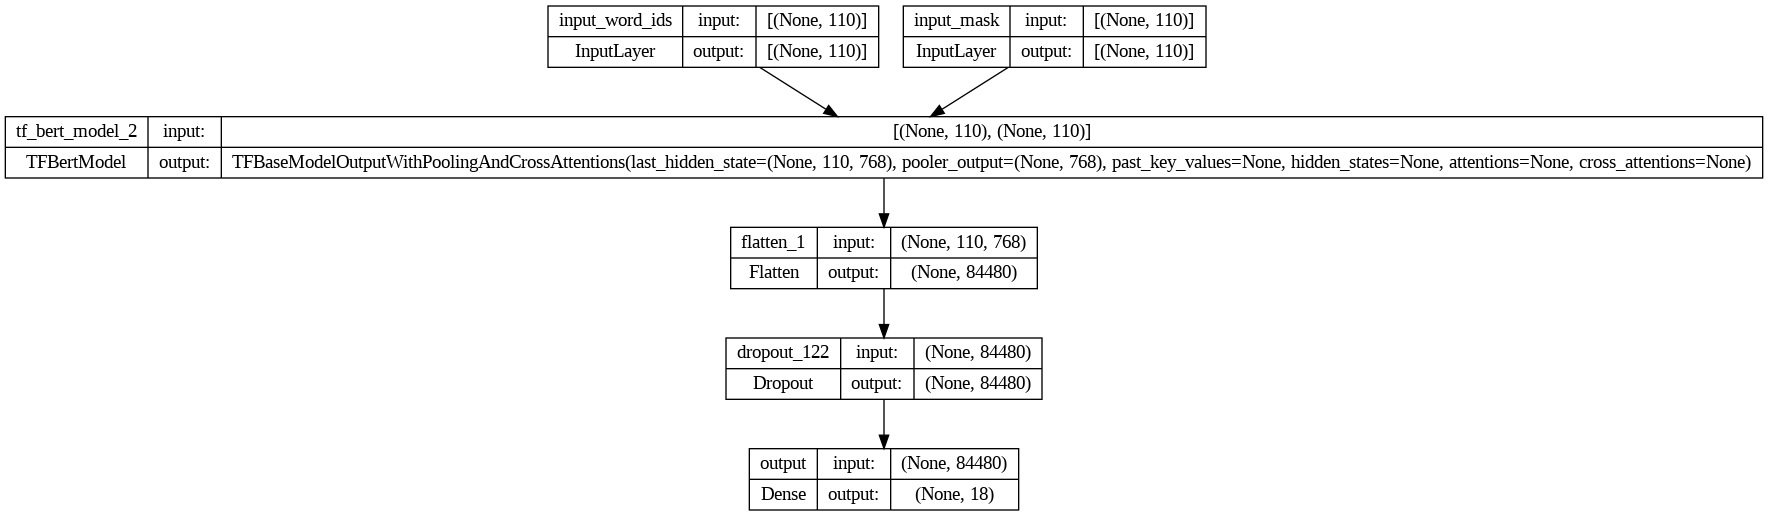

In [62]:
from tensorflow.keras.utils import plot_model
plot_model(multiclass_model,"modelarhcitect.png",show_shapes=True)

In [ ]:
# # Define the model
# def create_model():
#     input_ids = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="length_of_news_input")
#     attention_mask = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="length_of_news_mask")

#     # Using IndoBert as the base model
#     sequence_output = IndoBert(input_ids, attention_mask=attention_mask).last_hidden_state

#     # Global average pooling layer
#     avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

#     # Dense layer with softmax activation for classification
#     output = tf.keras.layers.Dense(18, activation="softmax")(avg_pooling)

#     # Build and compile the model
#     model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # You may adjust the learning rate
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Create the model
# with strategy.scope():  # If you're using TPU
#     model = create_model()

# # Display the model summary
# model.summary()

In [ ]:
# import tensorflow as tf
# from transformers import TFAutoModel

# # Maximum sequence length
# max_seq_length = 110

# # Define the model
# def create_model():
#     input_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="news_title_input")

#     # Using IndoBert as the base model
#     sequence_output = TFAutoModel.from_pretrained("indolem/indobert-base-uncased")(input_ids).last_hidden_state

#     # Global average pooling layer
#     avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

#     # Dense layer with softmax activation for classification
#     output = tf.keras.layers.Dense(18, activation="softmax")(avg_pooling)

#     # Build and compile the model
#     model = tf.keras.models.Model(inputs=input_ids, outputs=output)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # You may adjust the learning rate
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Create the model
# with strategy.scope():  # If you're using TPU
#     model = create_model()

# # Display the model summary
# model.summary()

In [ ]:
# # Define the model
# def create_model():
#     input_ids = tf.keras.layers.Input(shape=(110,), dtype=tf.int32, name="length_of_news_input")

#     # Using IndoBert as the base model
#     sequence_output = IndoBert(input_ids).last_hidden_state  # Remove attention_mask from IndoBert call

#     # Global average pooling layer
#     avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

#     # Dense layer with softmax activation for classification
#     output = tf.keras.layers.Dense(18, activation="softmax")(avg_pooling)

#     # Build and compile the model
#     model = tf.keras.models.Model(inputs=input_ids, outputs=output)  # Remove attention_mask from inputs
#     optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # You may adjust the learning rate
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Create the model
# with strategy.scope():  # If you're using TPU
#     model = create_model()

# # Display the model summary
# model.summary()

In [51]:
def get_optimizer(optimizer_name, lr):
    if optimizer_name == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer_name}')

In [56]:
import pandas as pd

# Learning rates and optimizers to try
learning_rates = [5e-5, 5e-3, 5e-1]
optimizers = ['adam', 'sgd', 'rmsprop']

# Initialize lists to store results
results = {'Optimizer': [], 'Learning Rate': [], 'Loss': [], 'Accuracy': []}

# Iterate over learning rates and optimizers
for lr in learning_rates:
    for optimizer_name in optimizers:
        # Build the model
        with strategy.scope():
            model = build_model()
            model.compile(optimizer=get_optimizer(optimizer_name, lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

        # Train the model
        history = model.fit(x = dataset, validation_data=dataVal, epochs=5, validation_data=dataVal)

        # Evaluate the model
        loss, accuracy = model.evaluate(dataVal)

        # Append results to lists
        results['Optimizer'].append(optimizer_name)
        results['Learning Rate'].append(lr)
        results['Loss'].append(loss)
        results['Accuracy'].append(accuracy)

# Create a summary dataframe
summary_df = pd.DataFrame(results)
print(summary_df)

SyntaxError: ignored

In [81]:
# # Learning rates and optimizers to try
# learning_rates = [5e-5, 5e-3, 5e-1]
# optimizers = ['adam', 'sgd', 'rmsprop']

# # Create an empty DataFrame to store results
# results_df = pd.DataFrame(columns=['Optimizer', 'Learning Rate', 'Loss', 'Accuracy'])

# # Update train_data dictionary keys to match the model's input layer names
# train_data = {
#     "length_of_news_input": tf.squeeze(tf.convert_to_tensor(tokens_train["length_of_news"]["input_ids"])),
# }

# # Iterate through combinations of learning rates and optimizers
# for lr in learning_rates:
#     for optimizer_name in optimizers:
#         with strategy.scope():  # If you're using TPU
#             model = create_model()

#         # Set IndoBert layer to be non-trainable
#         model.get_layer('tf_bert_model').trainable = False

#         # Display current configuration
#         print(f"\nTraining with {optimizer_name} optimizer and learning rate {lr}")

#         # Set optimizer based on the current configuration
#         if optimizer_name == 'adam':
#             optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#         elif optimizer_name == 'sgd':
#             optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#         elif optimizer_name == 'rmsprop':
#             optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

#         # Compile the model with the current optimizer
#         model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#         # Train the model with your data (assuming you have defined your data as train_data and validation_data)
#         history = model.fit(
#             train_data,
#             y_train,  # Ensure that the target data is provided here
#             validation_data=(validation_sequence, y_val),
#             epochs=2,  # Adjust the number of epochs as needed
#             batch_size=32,  # Adjust the batch size as needed
#         )

#         # Get the final training loss and accuracy
#         final_loss = history.history['loss'][-1]
#         final_accuracy = history.history['accuracy'][-1]

#         # Append the results to the DataFrame
#         results_df = results_df.append({
#             'Optimizer': optimizer_name,
#             'Learning Rate': lr,
#             'Loss': final_loss,
#             'Accuracy': final_accuracy
#         }, ignore_index=True)

# # Display the results DataFrame
# results_df


Training with adam optimizer and learning rate 5e-05
Epoch 1/2
109/109 [==============================] - ETA: 0s - loss: 2.9817 - accuracy: 0.0662

ValueError: ignored

# **Model v0**

In [25]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 42.22 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [26]:
!pip3 install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 136.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 126.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 41.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take in

In [33]:
ndf2

category                                     length_of_news  label
0        SDG5              resmi ketua dpr puan semringah banget      5
1       SDG16  muzani harap bamsoet mengalah serahkan kursi k...     16
2        SDG4         mahasiswa ui beasiswa vokasi pemkab serang      4
3       SDG11          kebakaran permukiman jalan s parman medan     11
4       SDG16  detikdetik penangkapan bandar jaringan lp tanj...     16
...       ...                                                ...    ...
4801    SDG17  indonesia dukung sistem kekayaan intelektual d...     17
4802    SDG17  jokowi top muslim berpengaruh pdip bantah fitn...     17
4803    SDG17  jokowi masuk muslim berpengaruh dunia pks hapu...     17
4804    SDG17  golkarpkb anggap jokowi layak masuk muslim ber...     17
4805    SDG17  pd nilai gelar muslim berpengaruh dunia cambuk...     17

[4806 rows x 3 columns]

In [34]:
from sklearn.model_selection import train_test_split

# Menggunakan random_state=42 untuk hasil yang dapat direproduksi
train_df, temp_df = train_test_split(ndf2, test_size=0.3, random_state=42, stratify=ndf2['label'])

# Membagi kembali sisa data menjadi valid_df (20%) dan test_df (10%)
valid_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42, stratify=temp_df['label'])

# Cetak panjang setiap bagian untuk memastikan pembagian yang benar
print("Jumlah data total:", len(ndf2))
print("Jumlah data training:", len(train_df))
print("Jumlah data validasi:", len(valid_df))
print("Jumlah data test:", len(test_df))

Jumlah data total: 4806
Jumlah data training: 3364
Jumlah data validasi: 961
Jumlah data test: 481


In [35]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.length_of_news.values, train_df.label.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.length_of_news.values, valid_df.label.values))
test_data = tf.data.Dataset.from_tensor_slices((test_df.length_of_news.values, test_df.label.values))

for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'nyamar pelajar sekuriti ditangkap polisi demo dpr', shape=(), dtype=string)
tf.Tensor(16, shape=(), dtype=int64)


In [29]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] # Label categories
max_seq_length = 110 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [43]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [44]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [45]:
# train
train_data = (train_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        #.cache()
                        .shuffle(1000)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

# valid
valid_data = (valid_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

In [46]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [47]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 110), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [52]:
from tqdm import tqdm
num_classes = 18

In [54]:
def create_multiclass_model(num_classes):
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    # You might want to use the sequence_output instead of pooled_output for more context-aware representations
    flatten = tf.keras.layers.Flatten()(sequence_output)

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)

    # Dense layer with num_classes neurons and softmax activation for multi-class classification
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="output")(drop)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output)

    return model

# Function to train the model with specified optimizer and learning rate
def train_model(model, optimizer, learning_rate, train_data, epochs):
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    model.fit(train_data, epochs=epochs, verbose=0)

# Define the optimizer and learning rate combinations
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.Adam, tf.keras.optimizers.Adam,
              tf.keras.optimizers.SGD, tf.keras.optimizers.SGD, tf.keras.optimizers.SGD]
learning_rates = [5e-5, 5e-3, 5e-1, 5e-5, 5e-3, 5e-1]

# Create a dataframe to store the summary
summary_df = pd.DataFrame(columns=['Optimizer', 'Learning Rate', 'Loss', 'Accuracy'])

# Iterate over each combination of optimizer and learning rate
for i in tqdm(range(len(optimizers))):
    # Create a new instance of the model for each iteration
    multiclass_model = create_multiclass_model(num_classes)

    # Train the model with the current optimizer and learning rate
    train_model(multiclass_model, optimizers[i], learning_rates[i], train_data, epochs=1)  # You can adjust the number of epochs

    # Evaluate the model on your validation data
    loss, accuracy = multiclass_model.evaluate(valid_data)

    # Append the results to the summary dataframe
    summary_df = summary_df.append({
        'Optimizer': optimizers[i].__name__,
        'Learning Rate': learning_rates[i],
        'Loss': loss,
        'Accuracy': accuracy
    }, ignore_index=True)

# Display the summary dataframe
print(summary_df)

  0%|          | 0/6 [00:00<?, ?it/s]

30/30 [==============================] - 8s 244ms/step - loss: 0.8919 - sparse_categorical_accuracy: 0.7437


 17%|█▋        | 1/6 [01:51<09:19, 111.94s/it]

30/30 [==============================] - 8s 235ms/step - loss: 3.0458 - sparse_categorical_accuracy: 0.0573


 33%|███▎      | 2/6 [03:39<07:17, 109.43s/it]

30/30 [==============================] - 8s 234ms/step - loss: 105.3832 - sparse_categorical_accuracy: 0.0552


 50%|█████     | 3/6 [05:25<05:23, 107.80s/it]

30/30 [==============================] - 8s 236ms/step - loss: 3.4697 - sparse_categorical_accuracy: 0.0552


 67%|██████▋   | 4/6 [07:00<03:25, 102.70s/it]

30/30 [==============================] - 8s 235ms/step - loss: 2.9420 - sparse_categorical_accuracy: 0.0562


 83%|████████▎ | 5/6 [08:33<01:39, 99.30s/it] 

30/30 [==============================] - 8s 236ms/step - loss: 132.7077 - sparse_categorical_accuracy: 0.0552


100%|██████████| 6/6 [10:07<00:00, 101.21s/it]

  Optimizer  Learning Rate        Loss  Accuracy
0      Adam        0.00005    0.891935  0.743750
1      Adam        0.00500    3.045839  0.057292
2      Adam        0.50000  105.383179  0.055208
3       SGD        0.00005    3.469740  0.055208
4       SGD        0.00500    2.941993  0.056250
5       SGD        0.50000  132.707703  0.055208


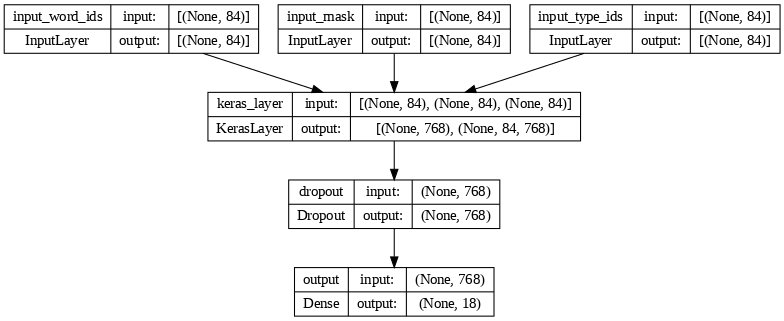

In [68]:
tf.keras.utils.plot_model(model=multiclass_model,show_shapes=True,dpi=76)

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming you have your training data (train_data) and validation data (valid_data) ready

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.2, random_state=42)

# Define the learning rates and optimizers to be tested
learning_rates = [5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
optimizers = ['sgd', 'adam', 'rmsprop']

# Store results in a dictionary
results = {'learning_rate': [], 'optimizer': [], 'accuracy': [], 'loss': []}

# Iterate over learning rates and optimizers
for lr in learning_rates:
    for optimizer_name in optimizers:
        print(f"Training with learning rate {lr} and optimizer {optimizer_name}")

        # Create the model
        multiclass_model = create_multiclass_model(num_classes)

        # Compile the model with the current learning rate and optimizer
        if optimizer_name == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        elif optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        multiclass_model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

        # Train the model using tf.data.Dataset pipelines
        history = multiclass_model.fit(
            train_data,
            epochs=epochs,
            validation_data=valid_data
        )

        # Get the final accuracy and loss from the training history
        final_accuracy = history.history['val_sparse_categorical_accuracy'][-1]
        final_loss = history.history['val_loss'][-1]

        # Store the results
        results['learning_rate'].append(lr)
        results['optimizer'].append(optimizer_name)
        results['accuracy'].append(final_accuracy)
        results['loss'].append(final_loss)

# Convert results to a pandas DataFrame for better display
import pandas as pd
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

NameError: ignored

In [69]:
# Train modelepochs=10
history = multiclass_model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    verbose=1)

Epoch 1/20
120/120 [==============================] - 54s 202ms/step - loss: 3.3569 - sparse_categorical_accuracy: 0.0513 - val_loss: 3.1277 - val_sparse_categorical_accuracy: 0.0521
Epoch 2/20
120/120 [==============================] - 24s 196ms/step - loss: 3.2788 - sparse_categorical_accuracy: 0.0503 - val_loss: 3.0764 - val_sparse_categorical_accuracy: 0.0594
Epoch 3/20
120/120 [==============================] - 24s 196ms/step - loss: 3.2424 - sparse_categorical_accuracy: 0.0490 - val_loss: 3.0364 - val_sparse_categorical_accuracy: 0.0562
Epoch 4/20
120/120 [==============================] - 25s 197ms/step - loss: 3.1923 - sparse_categorical_accuracy: 0.0542 - val_loss: 3.0055 - val_sparse_categorical_accuracy: 0.0573
Epoch 5/20
120/120 [==============================] - 24s 196ms/step - loss: 3.1579 - sparse_categorical_accuracy: 0.0560 - val_loss: 2.9808 - val_sparse_categorical_accuracy: 0.0594
Epoch 6/20
120/120 [==============================] - 25s 197ms/step - loss: 3.1078 -

In [70]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

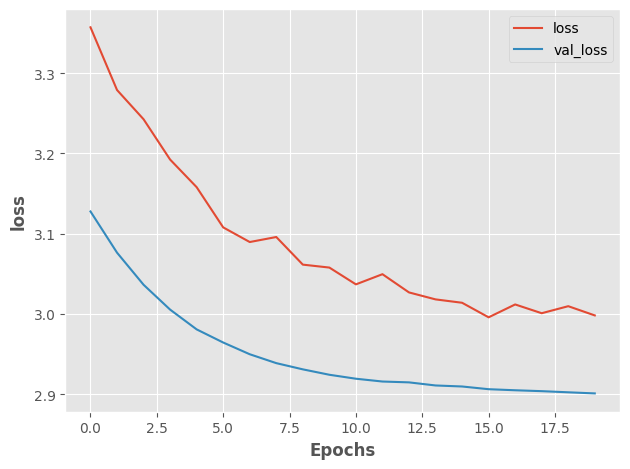

In [71]:
plot_graphs(history,'loss')

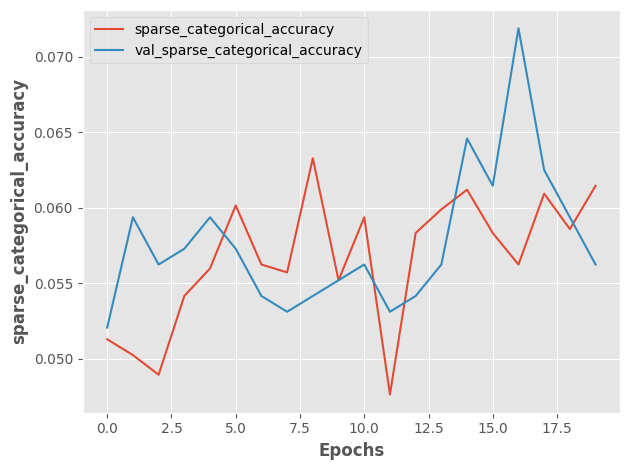

In [72]:
plot_graphs(history,'sparse_categorical_accuracy')

# **Tokenizing**

In [19]:
# def regular_encode(texts, tokenizer, maxlen=512):
#     enc_di = tokenizer.batch_encode_plus(
#         texts,
#         return_attention_masks=False,
#         return_token_type_ids=False,
#         pad_to_max_length=True,
#         max_length=maxlen
#     )

#     return np.array(enc_di['input_ids'])

In [19]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [30]:
ndf2

category                                     length_of_news  label
0        SDG5              resmi ketua dpr puan semringah banget      5
1       SDG16  muzani harap bamsoet mengalah serahkan kursi k...     16
2        SDG4         mahasiswa ui beasiswa vokasi pemkab serang      4
3       SDG11          kebakaran permukiman jalan s parman medan     11
4       SDG16  detikdetik penangkapan bandar jaringan lp tanj...     16
...       ...                                                ...    ...
4801    SDG17  indonesia dukung sistem kekayaan intelektual d...     17
4802    SDG17  jokowi top muslim berpengaruh pdip bantah fitn...     17
4803    SDG17  jokowi masuk muslim berpengaruh dunia pks hapu...     17
4804    SDG17  golkarpkb anggap jokowi layak masuk muslim ber...     17
4805    SDG17  pd nilai gelar muslim berpengaruh dunia cambuk...     17

[4806 rows x 3 columns]

In [31]:
from sklearn.model_selection import train_test_split

# Split the data into training (90%) and testing (10%)
train_df, test_df = train_test_split(ndf2, test_size=0.1, random_state=42)

# Split the training data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting DataFrames
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Testing data shape:", test_df.shape)

Training data shape: (3460, 3)
Validation data shape: (865, 3)
Testing data shape: (481, 3)


In [22]:
# Training data only
sentences = train_df.length_of_news
labels = train_df.label

# Validation data only
val_sentences = val_df.length_of_news
val_labels = val_df.label

# Testing data only
test_sentences = test_df.length_of_news
test_labels = test_df.label

In [23]:
import statistics
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  19.795086705202312
Median length =  20.0


In [102]:
# from transformers import BertTokenizer
# import torch

# # Load pre-trained tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# # Tokenization untuk training data
# encoded_train_sequences = tokenizer.encode_plus(
#     text=train_df.length_of_news.tolist(),  # Kalimat-kalimat training
#     add_special_tokens=True,
#     max_length=110,
#     padding="max_length",
#     truncation=True,
#     return_attention_mask=True,
#     return_tensors="pt"
# )

# # Tokenization untuk testing data
# encoded_test_sequences = tokenizer.encode_plus(
#     text=test_df.length_of_news.tolist(),  # Kalimat-kalimat testing
#     add_special_tokens=True,
#     max_length=110,
#     padding="max_length",
#     truncation=True,
#     return_attention_mask=True,
#     return_tensors="pt"
# )

# # Hasil tokenization untuk training data
# train_input_ids = encoded_train_sequences['input_ids']
# train_attention_mask = encoded_train_sequences['attention_mask']
# train_labels = torch.tensor(train_df.label.tolist())  # Konversi label menjadi tensor PyTorch

# # Hasil tokenization untuk testing data
# test_input_ids = encoded_test_sequences['input_ids']
# test_attention_mask = encoded_test_sequences['attention_mask']
# test_labels = torch.tensor(test_df.label.tolist())  # Konversi label menjadi tensor PyTorch

In [24]:
# Tokenization untuk training data (baris pertama)
encoded_train_sequences = tokenizer(sentences.iloc[0],
                                    add_special_tokens=True,
                                    max_length=110,
                                    padding="max_length",
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors="pt"
)

# Tokenization untuk validation data (baris pertama)
encoded_val_sequences = tokenizer(val_sentences.iloc[0],
                                  add_special_tokens=True,
                                  max_length=110,
                                  padding="max_length",
                                  truncation=True,
                                  return_attention_mask=True,
                                  return_tensors="pt"
)

# Tokenization untuk testing data (baris pertama)
encoded_test_sequences = tokenizer(test_sentences.iloc[0],
                                   add_special_tokens=True,
                                   max_length=110,
                                   padding="max_length",
                                   truncation=True,
                                   return_attention_mask=True,
                                   return_tensors="pt"
)

# Cetak hasil tokenization untuk training data (baris pertama)
print("Training Data - Sample 1")
print("Kalimat Asli:", sentences.iloc[0])
print("Token ID:", encoded_train_sequences['input_ids'])
print("Attention Mask:", encoded_train_sequences['attention_mask'])
print("Label:", labels.iloc[0].item())
print("\n")

# Cetak hasil tokenization untuk validation data (baris pertama)
print("Validation Data - Sample 1")
print("Kalimat Asli:", val_sentences.iloc[0])
print("Token ID:", encoded_val_sequences['input_ids'])
print("Attention Mask:", encoded_val_sequences['attention_mask'])
print("Label:", val_labels.iloc[0].item())
print("\n")

# Cetak hasil tokenization untuk testing data (baris pertama)
print("Testing Data - Sample 1")
print("Kalimat Asli:", test_sentences.iloc[0])
print("Token ID:", encoded_test_sequences['input_ids'])
print("Attention Mask:", encoded_test_sequences['attention_mask'])
print("Label:", test_labels.iloc[0].item())
print("\n")

Training Data - Sample 1
Kalimat Asli: mendagri penghargaan daerah terinovatif daftar penerimanya
Token ID: tensor([[  101,  2273,  2850, 16523,  2072, 26473,  8167,  3654,  2319,  4830,
          6906,  2232, 28774,  5740, 20203,  2546,  4830,  6199,  2906,  7279,
         11124,  2386,  3148,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tenso

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset

In [26]:
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=18)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
train_dataset = TensorDataset(encoded_train_sequences['input_ids'],
                              encoded_train_sequences['attention_mask'],
                              labels)

val_dataset = TensorDataset(encoded_val_sequences['input_ids'],
                            encoded_val_sequences['attention_mask'],
                            val_labels)

test_dataset = TensorDataset(encoded_test_sequences['input_ids'],
                             encoded_test_sequences['attention_mask'],
                             test_labels)

TypeError: ignored

In [25]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
import torch

In [26]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length=110)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # Tokenize the text
        encoded_sequence = self.tokenizer(
            text=self.sentences.iloc[idx],
            add_special_tokens=True,
            max_length=110,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoded_sequence['input_ids'].squeeze(),
            'attention_mask': encoded_sequence['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Create custom datasets
train_dataset = CustomDataset(sentences=sentences, labels=labels)
val_dataset = CustomDataset(sentences=val_sentences, labels=val_labels)
test_dataset = CustomDataset(sentences=test_sentences, labels=test_labels)

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler=RandomSampler(train_dataset),  # Select batches randomly
    batch_size=batch_size  # Trains with this batch size.
)

# For validation, the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
    val_dataset,  # The validation samples.
    sampler=SequentialSampler(val_dataset),  # Pull out batches sequentially.
    batch_size=batch_size  # Evaluate with this batch size.
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [116]:
# from torch.utils.data import Dataset

# class CustomDataset(Dataset):
#     def __init__(self, sentences, labels):
#         self.sentences = sentences
#         self.labels = labels
#         self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length=110)

#     def __len__(self):
#         return len(self.sentences)

#     def __getitem__(self, idx):
#         # Tokenize the text
#         encoded_sequence = self.tokenizer(
#             text=self.sentences.iloc[idx],
#             add_special_tokens=True,
#             max_length=110,
#             padding="max_length",
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors="pt"
#         )

#         return {
#             'input_ids': encoded_sequence['input_ids'].squeeze(),
#             'attention_mask': encoded_sequence['attention_mask'].squeeze(),
#             'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
#         }

# # Create custom datasets
# train_dataset = CustomDataset(sentences=sentences, labels=labels)
# val_dataset = CustomDataset(sentences=val_sentences, labels=val_labels)
# test_dataset = CustomDataset(sentences=test_sentences, labels=test_labels)

# # For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
# batch_size = 32

# # Create the DataLoaders for our training and validation sets.
# # We'll take training samples in random order.
# train_dataloader = DataLoader(
#     train_dataset,  # The training samples.
#     sampler=RandomSampler(train_dataset),  # Select batches randomly
#     batch_size=batch_size  # Trains with this batch size.
# )

# # For validation, the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#     val_dataset,  # The validation samples.
#     sampler=SequentialSampler(val_dataset),  # Pull out batches sequentially.
#     batch_size=batch_size  # Evaluate with this batch size.
# )

In [ ]:
# from sklearn.model_selection import train_test_split

# # Assuming ndf2, 'headline', and 'label' are defined correctly
# # First split into training and a temporary set
# X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
#     ndf2['length_of_news'],
#     ndf2['label'],
#     random_state=42,
#     test_size=0.3  # 70% training, 30% temporary set (which includes both testing and validation)
# )

# # Second split the temporary set into testing and validation
# X_test, X_val, y_test, y_val = train_test_split(
#     X_temp,
#     y_temp,
#     random_state=42,
#     test_size=0.67  # 10% testing, 20% validation
# )

# # Check the shapes of the split datasets
# print("X_train shape:", X_train_temp.shape)
# print("X_test shape:", X_test.shape)
# print("X_val shape:", X_val.shape)
# print("y_train shape:", y_train_temp.shape)
# print("y_test shape:", y_test.shape)
# print("y_val shape:", y_val.shape)

In [ ]:
# import torch

# # Tokenizing the news descriptions and converting the categories into one hot vectors
# Xtrain_encoded = torch.tensor(regular_encode(X_train.astype('str'), tokenizer, maxlen=110), dtype=torch.long)
# ytrain_encoded = torch.tensor(tf.keras.utils.to_categorical(y_train, num_classes=18, dtype='int32'), dtype=torch.float32)
# Xtest_encoded = torch.tensor(regular_encode(X_test.astype('str'), tokenizer, maxlen=110), dtype=torch.long)
# ytest_encoded = torch.tensor(tf.keras.utils.to_categorical(y_test, num_classes=18, dtype='int32'), dtype=torch.float32)
# Xval_encoded = torch.tensor(regular_encode(X_val.astype('str'), tokenizer, maxlen=110), dtype=torch.long)
# yval_encoded = torch.tensor(tf.keras.utils.to_categorical(y_val, num_classes=18, dtype='int32'), dtype=torch.float32)

In [ ]:
# sample_index = 1

# # Tampilkan teks asli
# print("Teks Asli (sebelum tokenisasi):", X_train.iloc[sample_index])

# # Tampilkan hasil tokenisasi
# print("\nHasil Tokenisasi:")
# print(Xtrain_encoded[sample_index])

# # Melakukan de-tokenisasi
# decoded_text = tokenizer.decode(Xtrain_encoded[sample_index], skip_special_tokens=True)
# print("\nTeks Setelah De-Tokenisasi:", decoded_text)

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Create TensorDatasets
# train_dataset = TensorDataset(Xtrain_encoded, ytrain_encoded)
# val_dataset = TensorDataset(Xval_encoded, yval_encoded)

# # Set batch size
# batch_size = 32

# # Create PyTorch DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Check the number of batches in each dataset
# num_train_batches = len(train_dataloader)
# num_val_batches = len(validation_dataloader)

# print("Number of batches in training dataset:", num_train_batches)
# print("Number of batches in validation dataset:", num_val_batches)

In [27]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 18,
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [30]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 109


In [31]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [34]:
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Inspect the structure of the batch
        print("Batch structure:", batch)

        # Access elements from the batch
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # Extract the loss and logits from the outputs
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Extract the loss and logits from the outputs
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

Streaming output truncated to the last 5000 lines.
        [  101,  7632,  2226,  ...,     0,     0,     0],
        [  101, 14719,  2483,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([ 4, 14,  8, 16, 12,  0, 15,  5,  1, 12, 17, 16,  7,  1,  3, 10, 16,  5,
         1,  6, 13,  5,  8,  8, 16,  4,  4, 13,  4, 13, 14,  1])}
Batch structure: {'input_ids': tensor([[  101,  2162,  3654,  ...,     0,     0,     0],
        [  101,  2162,  3654,  ...,     0,     0,     0],
        [  101, 19739,  5677,  ...,     0,     0,     0],
        ...,
        [  101,  2162,  3654,  ...,     0,     0,     0],
        [  101, 28919,  5484,  ...,     0,     0,     0],
        [  101,  8962, 13465,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0,

In [35]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.float_format', '{:.2f}'.format)


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

NameError: ignored

# **Model Building**

In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=84):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 18 neurons as the number of unique categories is 18.
    out = tf.keras.layers.Dense(18, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import transformers
from transformers import TFAutoModel

# # Import modul TPU dari tensorflow
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
model = build_model(transformer_layer, max_len=84)
model.summary()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 84)]              0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   335141888 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 84, 1024),                       
                              pooler_output=(None, 1             
                             024),                               
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [ ]:
#creating the training and testing dataset.
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
# Menetapkan layers pooler untuk non-trainable
for layer in model.layers[1].layers:
    if 'pooler' in layer.name:
        layer.trainable = False

In [ ]:
# Assuming train_dataset and test_dataset are instances of tf.data.Dataset

# Training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10,
    validation_data=test_dataset  # Assuming you want to use test_dataset for validation
)

Epoch 1/10
120/120 [==============================] - 210s 2s/step - loss: 2.9507 - accuracy: 0.0534 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
 27/120 [=====>........................] - ETA: 2:38 - loss: 2.9390 - accuracy: 0.0567

KeyboardInterrupt: ignored

# Model Build v2

In [ ]:
#creating the training and testing dataset.
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
def create_multiclass_model(num_classes):
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    # You might want to use the sequence_output instead of pooled_output for more context-aware representations
    # flatten = tf.keras.layers.Flatten()(sequence_output)

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)

    # Dense layer with num_classes neurons and softmax activation for multi-class classification
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="output")(drop)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output)

    return model

# Create a multi-class model with 18 classes
num_classes = 18
multiclass_model = create_multiclass_model(num_classes)

# Compile the model with appropriate settings for multi-class classification
multiclass_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Display the model summary
multiclass_model.summary()

NameError: ignored

In [ ]:
# Train model
epochs=5
history = multiclass_model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)